# Easy Deep Learning with Keras over Tensorflow: Image Classification

## Scope: Intro to industry-standard tool. We won't be diving into the math.

## What's Keras?
Python wrapper API over TensorFlow or Theano. Maintained by a Googler.

## Who uses it?
According to Udacity's autonomous vehicle engineering curriculum, the list of companies using it includes: Uber, comma.ai (open source self-driving car software)

## Keras Config
* TensorFlow is the default backend
* Theano is the other one
* The backends have their own input image dimension ordering conventions -- (pixel width, height, color channels) vs. (color channels, width, height)

In [1]:
!cat ~/.keras/keras.json

{
    "backend": "tensorflow",
    "epsilon": 1e-07,
    "floatx": "float32",
    "image_dim_ordering": "tf"
}


### (share GPU RAM among us)

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
simultaneous_users_count = 2
config.gpu_options.per_process_gpu_memory_fraction = 1.0 / simultaneous_users_count
set_session(tf.Session(config=config))

Using TensorFlow backend.


### Training & Validation Data Directory Structure Setup

In [3]:
from glob import glob
import os

shared_data_path = '/usr/local/share/kaggle/dogs-vs-cats-redux-kernels-edition'
shared_training_data_path = shared_data_path + '/train'
shared_training_images_filepaths = glob(os.path.join(shared_training_data_path, "*.*.*"))

In [4]:
project_data_path = 'data'
sample_path = project_data_path + '/sample'

current_data_path = sample_path
training_path = current_data_path + '/training'
validation_path = current_data_path + '/validation'

classes = ['cat', 'dog']

for c in classes:
    for path in [training_path, validation_path]:
        !mkdir -p {path}/{c}

In [5]:
from img_paths import clear_training_validation_directories, extract_label, sample_paths_labels, symlink_files
from sklearn.model_selection import train_test_split

sample_percentage = 1.0 / simultaneous_users_count
sample_filepaths, sample_labels = sample_paths_labels(shared_training_images_filepaths, sample_percentage)
training_filepaths, validation_filepaths, training_labels, validation_labels = train_test_split(sample_filepaths, 
                                                                                                sample_labels)
clear_training_validation_directories(current_data_path, classes)
symlink_files(shared_training_data_path, current_data_path, 'training', training_filepaths, training_labels)
symlink_files(shared_training_data_path, current_data_path, 'validation', validation_filepaths, validation_labels)

# EDA

## Class Balance

In [6]:
!ls -al {shared_data_path}/train/cat.*.jpg | wc -l
!ls -al {shared_data_path}/train/dog.*.jpg | wc -l

12500
12500


## Image Sizes

In [7]:
from img_stats import dimension_counts

image_dimensions_counts = dimension_counts(shared_training_images_filepaths)

### Distinct Dimensions

In [8]:
print(len(image_dimensions_counts))

8513


### Most Common Dimensions

In [9]:
import operator

sorted(image_dimensions_counts.items(), key=operator.itemgetter(1), reverse=True)[:10]

[((500, 374), 2955),
 ((499, 375), 2912),
 ((375, 499), 261),
 ((499, 333), 229),
 ((374, 500), 227),
 ((319, 240), 207),
 ((500, 332), 200),
 ((320, 239), 192),
 ((500, 373), 101),
 ((500, 331), 95)]

## Given the wide variety of image sizes, how well will a neural network perform? Let's find out...

# ImageNet-Trained Models

## What is ImageNet?

## Keras includes some pre-trained models. You may find other open source Keras models out in the wild.

## VGG16 is a decent one to start with. Winner of ImageNet 2014. Relatively small architecture & quick to train.

In [10]:
from keras.applications.vgg16 import VGG16

pretrained_model = VGG16()

### Let's feed it a non-ImageNet image and see what it predicts

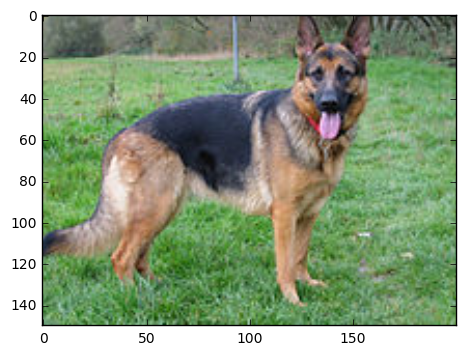

In [11]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt

test_img = Image.open('dog.jpg')
plt.imshow(test_img)

### Note that VGG16 expects 224X224 images by default, so the image is resized before feeding it to the model

top 5 predictions [('malinois', 0.40264007), ('German shepherd, German shepherd dog, German police dog, alsatian', 0.16363731), ('Ibizan hound, Ibizan Podenco', 0.13665552), ('Saluki, gazelle hound', 0.1223571), ('kelpie', 0.067595862)]


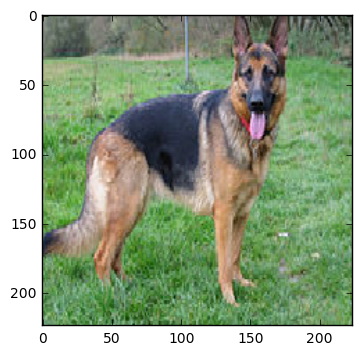

In [12]:
#!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/596b27d23537e5a1b5751d2b0481ef172f58b539/imagenet1000_clsid_to_human.txt
import ast
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

with open('imagenet1000_clsid_to_human.txt') as imagenet1kclasses_file:
    imagenet_classes = ast.literal_eval(imagenet1kclasses_file.read())

resized_img = load_img('dog.jpg', target_size=(224, 224))
plt.imshow(resized_img)
img_array = np.asarray([img_to_array(resized_img)])

predictions = pretrained_model.predict(img_array, batch_size=1)

top5indices = np.argsort(predictions, axis=1)[0][::-1][:5]
top5predictions = [(imagenet_classes[i], predictions[0][i]) for i in top5indices]
print('top 5 predictions', top5predictions)

### A more challenging image...

top 5 predictions [('brassiere, bra, bandeau', 0.37033799), ('Great Dane', 0.13329917), ('oxygen mask', 0.074079819), ('gasmask, respirator, gas helmet', 0.052083101), ('pedestal, plinth, footstall', 0.031974003)]


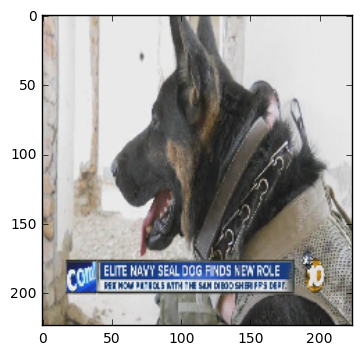

In [13]:
resized_img = load_img('nonimagenet.jpg', target_size=(224, 224))
plt.imshow(resized_img)
img_array = np.asarray([img_to_array(resized_img)])

predictions = pretrained_model.predict(img_array, batch_size=1)

top5indices = np.argsort(predictions, axis=1)[0][::-1][:5]
top5predictions = [(imagenet_classes[i], predictions[0][i]) for i in top5indices]
print('top 5 predictions', top5predictions)

## If you're curious about what the model looks like...

### Text Summary

In [14]:
pretrained_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

## Keras' Generated Image

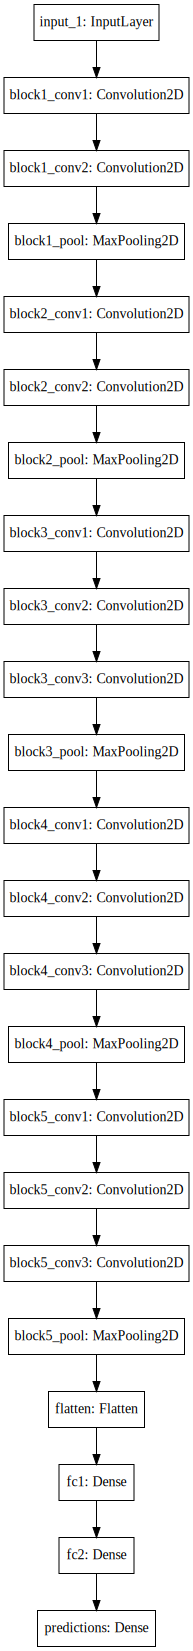

In [15]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(pretrained_model).create(prog='dot', format='svg'))

## TensorBoard (Chrome browser only)

In [16]:
from tf_viz import show_graph
import tensorflow as tf

show_graph(tf.get_default_graph().as_graph_def())

But this diagram may be more useful:
![VGG16](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

# Transfer Learning

In [16]:
from keras.layers import Input

pixels = 224
color_channels = 3
base_model = VGG16(include_top=False, input_tensor=Input(shape=(pixels, pixels, color_channels)))


#### Image Generators

In [17]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = int(64 / simultaneous_users_count)
pixels = 224
target_size = (pixels, pixels)

data_generator = ImageDataGenerator()
training_generator = data_generator.flow_from_directory(training_path, 
                                                        target_size=target_size, 
                                                        batch_size=batch_size, 
                                                        class_mode=None, 
                                                        shuffle=False)
validation_generator = data_generator.flow_from_directory(validation_path, 
                                                          target_size=target_size, 
                                                          batch_size=batch_size, 
                                                          class_mode=None, 
                                                          shuffle=False)

Found 9375 images belonging to 2 classes.
Found 3125 images belonging to 2 classes.


### Bottleneck Features
Imagine the CNN in the shape of a beer bottle. The fully connected / dense layers are the "neck."

In [18]:
training_intermediate_output = base_model.predict_generator(training_generator, len(training_filepaths))
validation_intermediate_output = base_model.predict_generator(validation_generator, len(validation_filepaths))

##### Save intermediate output just in case... 

In [19]:
from bcolz_files import save_array

!rm -rf {current_data_path}/*.bcolz

save_array(current_data_path + '/training.bcolz', training_intermediate_output)
save_array(current_data_path + '/validation.bcolz', validation_intermediate_output)

#### Deriving training labels

In [20]:
cat_training_images_filepaths = glob(os.path.join(training_path + '/cat', "*.*.*"))
cat_training_images_count = len(cat_training_images_filepaths)

dog_training_images_filepaths = glob(os.path.join(training_path + '/dog', "*.*.*"))
dog_training_images_count = len(dog_training_images_filepaths)


cat_validation_images_filepaths = glob(os.path.join(validation_path + '/cat', '*.*.*'))
dog_validation_images_filepaths = glob(os.path.join(validation_path + '/dog', '*.*.*'))
cat_validation_images_count = len(cat_validation_images_filepaths)
dog_validation_images_count = len(dog_validation_images_filepaths)

In [21]:
bottleneck_training_labels = np.array([0] * cat_training_images_count + [1] * dog_training_images_count)
bottleneck_validation_labels = np.array([0] * cat_validation_images_count + [1] * dog_validation_images_count)

In [42]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout, ELU, Flatten

classes_count = len(classes)
top_model = Sequential([
        Flatten(input_shape=training_intermediate_output.shape[1:]),
        ELU(),
        Dense(512),
        Dropout(0.5),
        Dense(classes_count, activation='softmax', name='predictions')
    ])

top_model.compile(optimizer='adam', # NOTE: several optimizers to choose from besides regular gradient descent
                  loss='categorical_crossentropy', # NOTE: several error metrics to choose from (e.g., MSE for regression)
                  metrics=['accuracy'])

In [23]:
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

max_epochs = 8

early_stopping = EarlyStopping(patience=2, verbose=1)

!rm {current_data_path}/*.hdf5
checkpoint = ModelCheckpoint(filepath=current_data_path+"/weights.{epoch:02d}-{val_loss:.5f}.hdf5", 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=True)
learning_rate_reducer = ReduceLROnPlateau(patience=1, verbose=1)

top_model.fit(training_intermediate_output, to_categorical(bottleneck_training_labels),
              batch_size=batch_size,
              nb_epoch=max_epochs, 
              callbacks=[checkpoint, learning_rate_reducer, early_stopping],
              validation_data=(validation_intermediate_output, to_categorical(bottleneck_validation_labels))
              )

Train on 9375 samples, validate on 3125 samples
Epoch 1/8
9375/9375 [==============================] - 5s - loss: 4.1588 - acc: 0.7411 - val_loss: 2.5035 - val_acc: 0.8432
Epoch 2/8
9375/9375 [==============================] - 4s - loss: 3.0118 - acc: 0.8128 - val_loss: 3.2228 - val_acc: 0.7997
Epoch 3/8
9375/9375 [==============================] - 4s - loss: 2.2036 - acc: 0.8630 - val_loss: 1.7478 - val_acc: 0.8915
Epoch 4/8
9375/9375 [==============================] - 4s - loss: 2.3835 - acc: 0.8521 - val_loss: 1.8376 - val_acc: 0.8854
Epoch 5/8
9375/9375 [==============================] - 4s - loss: 1.7942 - acc: 0.8882 - val_loss: 1.6980 - val_acc: 0.8944
Epoch 6/8
9375/9375 [==============================] - 4s - loss: 1.9528 - acc: 0.8787 - val_loss: 1.8620 - val_acc: 0.8845
Epoch 7/8
9375/9375 [==============================] - 4s - loss: 1.8964 - acc: 0.8822 - val_loss: 1.5211 - val_acc: 0.9056
Epoch 8/8
9375/9375 [==============================] - 4s - loss: 1.7979 - acc: 0.88

# Prediction Quality Check

In [24]:
best_model_weights_filename = 'weights.06-1.52106.hdf5'
top_model.load_weights(current_data_path + '/' + best_model_weights_filename)

validation_prediction_probabilities = top_model.predict_proba(validation_intermediate_output, batch_size=batch_size)

3104/3125 [============================>.] - ETA: 0s

In [25]:
errors = validation_prediction_probabilities[:, 1] - bottleneck_validation_labels
top_count = 4
worst_dog_prediction_indices = np.argsort(errors)[:top_count]
worst_cat_prediction_indices = np.argsort(errors)[::-1][:top_count]

In [31]:
validation_prediction_probabilities

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]], dtype=float32)

In [30]:
print([errors[i] for i in worst_dog_prediction_indices])
print([errors[i] for i in worst_cat_prediction_indices])

[-1.0, -1.0, -1.0, -1.0]
[1.0, 1.0, 1.0, 1.0]


In [26]:
validation_filepaths = cat_validation_images_filepaths + dog_validation_images_filepaths

### Misclassified as Cats

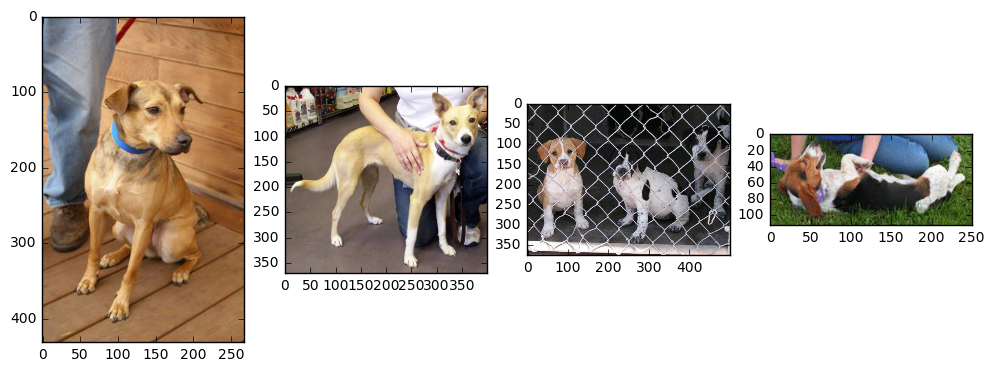

In [27]:
from img_paths import show

show([validation_filepaths[i] for i in worst_dog_prediction_indices])

### Misclassified as Dogs

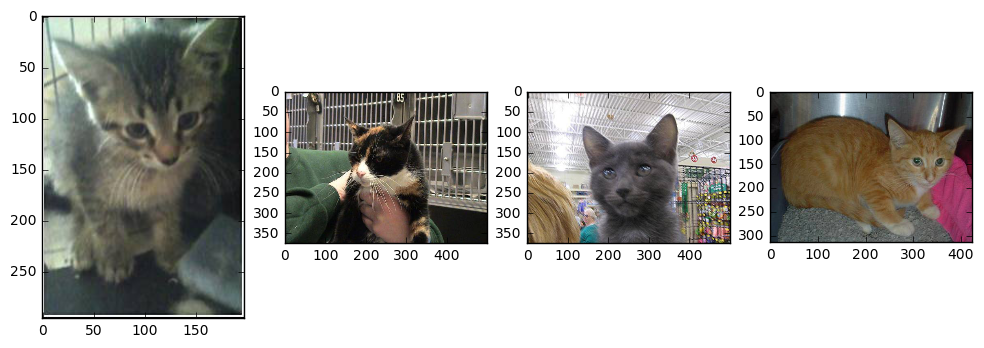

In [28]:
show([validation_filepaths[i] for i in worst_cat_prediction_indices])

### Most Uncertain
Probabilities closest to (1.0 / class_count)

In [29]:
most_uncertain_indices = np.argsort(np.abs(errors - (1.0 / classes_count)))
[errors[i] for i in most_uncertain_indices][:top_count]

[0.0, 0.0, 0.0, 0.0]

# Data Augmentation

In [32]:
augmentation_generator = ImageDataGenerator(rotation_range=5, 
                                            width_shift_range=0.1, 
                                            height_shift_range=0.1,
                                            shear_range=0.1,
                                            zoom_range=0.2,
                                            channel_shift_range=10.0,
                                            horizontal_flip=True)

In [33]:
augmented_img = np.expand_dims(resized_img, 0)

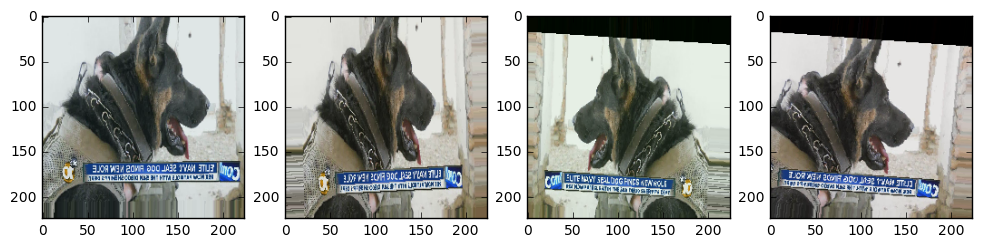

In [34]:
augmentation_iterator = augmentation_generator.flow(augmented_img)
augmented_images = [next(augmentation_iterator)[0].astype(np.uint8) for i in range(top_count)]

f = plt.figure(figsize=(12, 6))
rows = 1
for i in range(top_count):
    sp = f.add_subplot(rows, top_count//rows, i+1)
    img = augmented_images[i]
    plt.imshow(img)

In [53]:
augmented_training_generator = augmentation_generator.flow_from_directory(training_path, 
                                                                          target_size=target_size, 
                                                                          batch_size=batch_size, 
                                                                          #class_mode='None', # 'categorical' by default
                                                                          #shuffle=False # True by default
                                                                         )

Found 9375 images belonging to 2 classes.


In [56]:
fine_tuned_model = Sequential(base_model.layers)
for layer in fine_tuned_model.layers[:25]:
    layer.trainable = False

#top_model = Sequential([
#        Flatten(input_shape=base_model.output_shape[1:]),
#        ELU(),
#        Dense(512),
#        Dropout(0.5),
#        Dense(classes_count, activation='softmax', name='predictions')
#    ])
top_model.load_weights(current_data_path + '/' + best_model_weights_filename)
fine_tuned_model.add(top_model)

from keras.optimizers import SGD
fine_tuned_model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

categorical_validation_generator = data_generator.flow_from_directory(training_path, 
                                                                      target_size=target_size,
                                                                      batch_size=batch_size, 
                                                                      shuffle=False)

fine_tuned_model.fit_generator(augmented_training_generator, 
                               samples_per_epoch=len(training_filepaths)*2, # Note the increase in training set
                               nb_epoch=max_epochs, 
                               callbacks=[checkpoint, learning_rate_reducer, early_stopping],
                               validation_data=categorical_validation_generator, 
                               nb_val_samples=len(validation_filepaths))

Found 9375 images belonging to 2 classes.
Epoch 1/8
18750/18750 [==============================] - 223s - loss: 3.2170 - acc: 0.8003 - val_loss: 3.5121 - val_acc: 0.7816
Epoch 2/8
18750/18750 [==============================] - 219s - loss: 2.1782 - acc: 0.8648 - val_loss: 1.4031 - val_acc: 0.9129
Epoch 3/8
18750/18750 [==============================] - 219s - loss: 2.1226 - acc: 0.8682 - val_loss: 1.5064 - val_acc: 0.9065
Epoch 4/8
18750/18750 [==============================] - 220s - loss: 2.4249 - acc: 0.8495 - val_loss: 0.3547 - val_acc: 0.9780
Epoch 5/8
18750/18750 [==============================] - 221s - loss: 2.7160 - acc: 0.8314 - val_loss: 1.3240 - val_acc: 0.9177
Epoch 6/8
18718/18750 [============================>.] - ETA: 0s - loss: 2.4061 - acc: 0.8507Epoch 00005: val_loss did not improve

Epoch 00005: reducing learning rate to 9.999999747378752e-06.
18750/18750 [==============================] - 221s - loss: 2.4037 - acc: 0.8508 - val_loss: 1.1979 - val_acc: 0.9257
Epoch 

# More things to explore:
* Ensembling
* Pseudo-labeling
* Architectures

# Kaggle Submission

In [ ]:
!kg -u username -p "password" -c dogs-vs-cats-redux-kernels-edition submit submission.csv